# Previsão dos Jogos de Pós temporada da NBA

Autor: Eduardo Almeida M Neiva

"Considerando o crescente uso de ciência dos dados no mercardo esportivo e de especulação, nesta semana vocês farão parte de uma startup que quer quebrar os sites de apostas da NBA!

O mercado online de apostas foi avaliado em US$85.047 no ano de 2019 e pode ter um crescimento ainda maior nos próximos anos levando em consideração a posição favorável de alguns governos com a legalização das plataformas e pagamento de impostos.

Com isso, a startup de vocês, RodaRodaBet, após um estudo inicial sobre o mercado de apostas americano e dos dados disponíveis online sobre a NBA, está buscando a construção de um modelo que possa indicar se os times da casa irão ganhar ou perder em cada rodada da liga.

A formatação de todos os arquivos estão no formato Time Casa versus Time Fora, na qual os confrontos seguem os jogos dos playoffs, seguido dos atributos que cada equipe fez durante a temporada regular. Por fim, há um atributo classificador representado pelas letras W (win) ou L (lose), informando se o Time Casa saiu do confronto vitorioso ou derrotado."




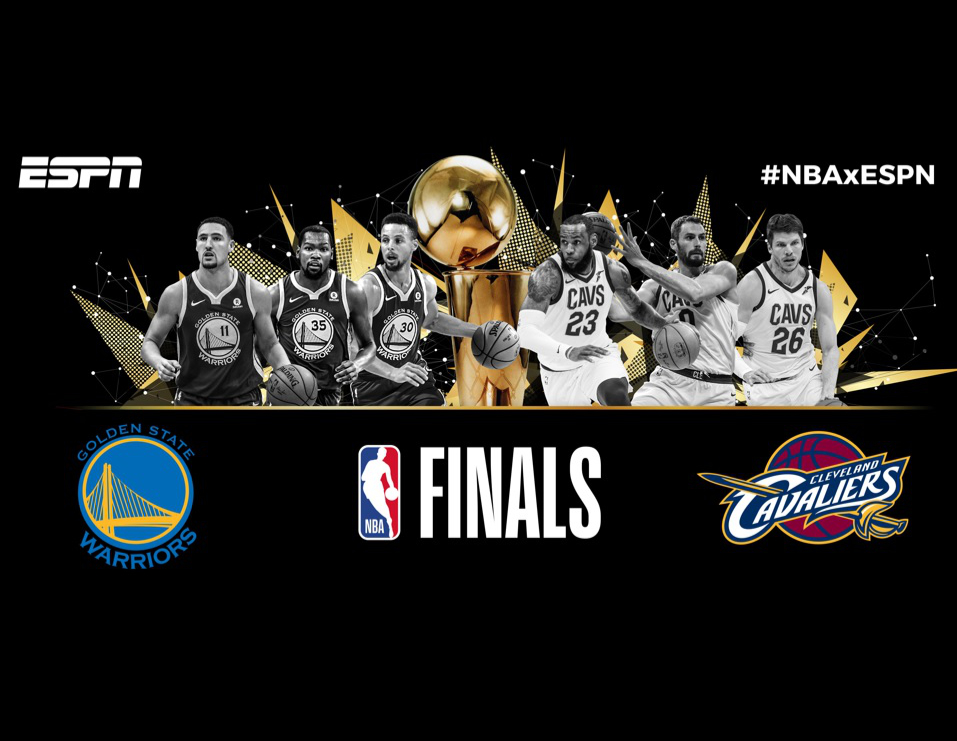

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, plot_confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.feature_extraction import DictVectorizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import warnings
warnings.filterwarnings('ignore')

In [151]:
treino = pd.read_csv('/content/drive/MyDrive/datasets/NBA/NBA.csv') #jogos 2006 a 2017 com resultado
teste = pd.read_csv('/content/drive/MyDrive/datasets/NBA/test_without_label.csv') #jogos 2018 e 2019 sem os resultados
resultados_teste =  pd.read_csv('/content/drive/MyDrive/datasets/NBA/test.csv') # resultados 2018 e 2019 
treino.head()

,Game,Data,H_Team,H_Wins,H_Loss,H_W/D %,H_SRS,H_Games,H_TotalPoints,H_AvgPointsPerGame,H_FG,H_FGA,H_FG%,H_3P,H_3PA,H_3P%,H_2P,H_2PA,H_2P%,H_FT,H_FTA,H_FT%,H_ORB,H_DRB,H_TRB,H_AST,H_BLK,H_TOV,H_PF,H_PointsOpp,H_AvgPointsPerGameOpp,H_OFG,H_OFGA,H_OFG%,H_O3P,H_O3PA,H_O3P%,H_O2P,H_O2PA,H_O2P%,...,A_PointsOpp,A_AvgPointsPerGameOpp,A_OFG,A_OFGA,A_OFG%,A_O3P,A_O3PA,A_O3P%,A_O2P,A_O2PA,A_O2P%,A_OFT,A_OFTA,A_OFT%,A_OORB,A_ODRB,A_OTRB,A_OAST,A_OBLK,A_OTOV,A_OPF,A_PW,A_PL,A_MOV,A_SOS,A_Ortg,A_Drtg,A_Pace,A_Ftr,A_3PAr,A_TS%,A_eFG%,A_TOV%,A_ORB%,A_FT/FGA,A_OeFG%,A_OTOV%,A_DRB%,A_OFT/FGA,WinOrLose
0,0,"Thu, June 8",Miami Heat,52,30,0.634,3.59,82,8191,99.9,37.1,77.5,0.478,6.1,17.6,0.345,31.0,59.9,0.517,19.7,28.2,0.700,10.5,32.6,43.1,20.6,5.4,14.5,22.8,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,...,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,26.4,0.752,11.4,26.9,38.3,17.5,4.9,14.0,23.9,58,24,6.07,-0.11,111.8,105.0,87.8,0.364,0.175,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
1,1,"Sun, June 11",Miami Heat,52,30,0.634,3.59,82,8191,99.9,37.1,77.5,0.478,6.1,17.6,0.345,31.0,59.9,0.517,19.7,28.2,0.700,10.5,32.6,43.1,20.6,5.4,14.5,22.8,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,...,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,26.4,0.752,11.4,26.9,38.3,17.5,4.9,14.0,23.9,58,24,6.07,-0.11,111.8,105.0,87.8,0.364,0.175,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,L
2,2,"Tue, June 13",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-0.27,108.7,104.5,91.6,0.363,0.227,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
3,3,"Thu, June 15",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-0.27,108.7,104.5,91.6,0.363,0.227,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L
4,4,"Sun, June 18",Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-0.27,108.7,104.5,91.6,0.363,0.227,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,L


## Pré Processamento

Nesta estapa será feita a criação de novas variáveis, as quais serão as diferenças entre as estatísticas do time de casa e do time visitante. Como os modelos não criam novas variáveis, nem sempre eles são capazes de perceber que a diferença de uma estatística entre os times pode ser muito mais relevante do que o valor dela em cada time.

Além disso, os nomes dos times serão codificados, pois os modelos não conseguem interpretar variáveis não numéricas. Como os times não são variáveis ordinais, a melhor alternativa seria criar dumies, ou seja, variáveis binárias que indicam a presença do time no jogo.

Também será criada uma função de padronização para avaliar o efeito desse processo na acurácia das previsões.

Os dados desse projeto não possuem problemas como informações faltantes ou inconsistentes, portanto nenhuma limpeza precisa ser feita.


In [157]:
# remove espaços em brancos antes e depois dos nomes das colunas
treino.columns = [col.strip() for col in treino.columns]
teste.columns = [col.strip() for col in teste.columns]


#função para criar estatísticas novas
def cria_var(train, treino=True):

    if treino:
        estat_home=train.iloc[:, 3:68] #seleciona estatística do time de casa
        estat_away=train.iloc[:, 69:-1] # começa da 69 para não pegar o nome do time de fora
    else:
        estat_home=train.iloc[:, 3:68]
        estat_away=train.iloc[:, 69:]

    # remove prefixos 'H_' e 'A_' das estatítiscas para possibilitar o uso do método sub
    estat_home.columns =  [col.split("_")[1] for col in estat_home.columns] 
    estat_away.columns =  [col.split("_")[1] for col in estat_away.columns]

    df = train.join(estat_home.sub(estat_away).add_prefix('Diff_')) # obtem as diferenças entre estatísticas de mesmo nome

    return df

# função para codificar vitória e derrota para 1 e 0.
def codifica(treino):

    df = treino.copy()
    df['WinOrLose'] = df.WinOrLose.str.replace('L', '0', regex=True)
    df['WinOrLose'] = df.WinOrLose.str.replace('W', '1', regex=True)

    return df

#função para padronizar os dados dos conjuntos de treino e teste
def padroniza(train, test):
    sc= StandardScaler()

    df_treino = sc.fit_transform(train)
    df_teste = sc.transform(test)

    return df_treino, df_teste

#função para codificar os times
def codifica_time(train, test):
    
    assert(train.shape[1]==test.shape[1]), "treino e teste tem colunas diferentes"

    X_dict = train.iloc[:,2:].to_dict(orient='records') #transforma o df em um dicionário e remove o ID do jogo e a data
    X_test_dict = test.iloc[:, 2:].to_dict(orient='records')

    dv_X = DictVectorizer(sparse=False) 
    X_encoded = dv_X.fit_transform(X_dict)
    X_test_encoded = dv_X.transform(X_test_dict)

    cols = dv_X.feature_names_

    X_encoded = pd.DataFrame(X_encoded, columns=cols)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=cols)

    return X_encoded, X_test_encoded


## Aplicação dos Estimadores

Inicialmente, serão geradas predições utilizando todas as variáveis que se tenha um parâmetro de acurácia. Depois, serão verificadas quais variáveis foram mais importantes para os modelos.

Serão testadas diferentes combinações de temporadas de 2006 à 2017 para os conjuntos de treino e teste para entender melhor o comportamento dos modelos em diferentes contextos da liga.

Os modelos testados serão KNN, Naive Bayes, SVM, Árvore de decisão, Random Forests, Adaboost e Gaussian Process.



In [166]:
# SEM padronização
treino_new = cria_var(treino)
teste_new = cria_var(teste, False)
treino_new = codifica(treino_new)

X_train = treino_new.iloc[:, :] #seleciona as temporadas para o ajuste do modelo
y_train=treino_new.loc[:, 'WinOrLose'] 
X_train.drop('WinOrLose',axis=1, inplace=True) #remove target

#X_test = treino_new.iloc[254:339, :] # temporada para teste
#y_test = treino_new.loc[254:338, 'WinOrLose']
#X_test.drop('WinOrLose', axis=1, inplace=True) #remove target


#X_train, X_test = codifica_time(X_train, X_test)



In [ ]:
# com padronização

X_train, X_test = padroniza(X_train, X_test)

In [ ]:
names = ["Nearest Neighbors", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "AdaBoost",
         "Naive Bayes"]
         
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel='rbf'),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=100, max_features=15),
    AdaBoostClassifier(), 
    GaussianNB()]

score=0
atual = 0
nome_maior = ""
acuracia_maior=0


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc=accuracy_score(y_test, y_pred)


    if atual < acc:
        nome_maior=name
        acuracia_maior=acc
        atual = acc


print("Maior acurácia foi ", nome_maior, "com ", acuracia_maior)


Maior acurácia foi  Naive Bayes com  0.6987951807228916


Temporadas p/ treino | Temporada p/ Teste | Maior Acurácia (sem padronização) | Maior acurácia (com padronização)
--- | --- | --- | --- 
2006-2008 | 2009 | 69,41% (SVM)               | 68,23% (SVM)
2010-2013 | 2014 | 60,67% (Naive Bayes)       | 60,67% (Naive Bayes)
2014-2016 | 2017 | 73,49% (Naive Bayes)       | 71,08% (Naive Bayes)
2006-2013 | 2014 | 59,55% (Naive Bayes)       | 59,55% (Árvore de Decisão)
2006-2014 | 2015 | 67,90% (Árvore de Decisão) |  65,43% (Árvore de Decisão)
2016      | 2017 | 69,88% (Naive Bayes)       | 63,85% (Naive Bayes) 
2006      | 2007 | 65,82% (SVM)               | 65,82% (SVM)
**2006**  | **2017** | 66,26% (AdaBoost)      | 66,26% (AdaBoost)

\\
Observa-se que o desempenho dos modelo varia bastante de acordo com as temporadas, porém, tal variação não é aleatória: as maiores acurácias foram obtidas para os anos mais recentes, que foram marcados pelo domínio do Golden State Warriors. O time, além de ter tido campanhas excelentes em temporada regular, chegou às finais em 3 anos consecutivos e foi campeão duas vezes, voltando à ganhar novamente em 2018. 

Os resultados mostram que tal contexto de hegemonia facilita as previsões e que a melhor estratégia é utilizar as temporadas que mais se assemelham à atual para o ajuste do modelo (o que não é nenhuma surpresa). Como podemos ver nas últimas três linhas da tabela, utilizar apenas uma temporada para o treino não foi uma estratégia ruim. Além disso, para o ano de 2014, foi mais eficiente ajustar o modelo com 4 temporadas do que com 8.

A última linha mostra um resultado bem curioso: uma acurácia relativamente alta para temporadas com 11 anos de diferença. Na verdade, esse resultado ocorre pela facilidade em classificar os jogos da temporada de 2017, como visto anteriormente. O mesmo ocorre se o modelo for ajustado com a temporada de 2007.

O uso de padronização é pior ou indiferente para a acurácia em quase todos os casos, por isso seu uso não será mais considerado a partir de agora. Esse resultado também será utilizado para descartar o uso de componentes principais, uma vez que a PCA depende fortemente de padronização.




## Seleção de Variáveis

Alguns dos modelos aplicados anteriormente atribuem pesos as variáveis; a partir disso é possível saber quais variáveis foram consideradas mais importantes e quais não foram utilizadas. O algoritmo Naive Bayes, embora tenha sido o melhor, não faz a seleção de variáveis.

Agora, as predições serão geradas reduzindo-se o espaço de variáveis às aquelas julgadas relevantes pelos modelos em cada caso.

In [119]:
names = [ 
        "LINEAR SVM", 
        "Decision Tree", 
        "Random Forest", 
        "AdaBoost"]
         
classifiers = [
    SVC(kernel='linear'),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=100, max_features=50),
    AdaBoostClassifier()]

score=0
atual = 0
nome_maior = ""
acuracia_maior=0



for name, clf in zip(names, classifiers):

    selector = SelectFromModel(clf).fit(X_train, y_train)
    X_train_selec= selector.transform(X_train)

    y_pred = clf.fit(X_train_selec,y_train).predict(selector.transform(X_test)) 
    
    acc = accuracy_score(y_test, y_pred)


    if atual < acc:
        nome_maior=name
        acuracia_maior=acc
        atual = acc
        features = selector.get_support()
        qtd = features.sum()


print("Maior acurácia foi ", nome_maior, "com ", acuracia_maior)
print("Número de variáveis utilizadas:", qtd )

Maior acurácia foi  Decision Tree com  0.6941176470588235
Número de variáveis utilizadas: 21


Temporadas p/ treino | Temporada p/ Teste | Menor Quantidade de variáveis utilizadas | Maior quantidade de variáveis
--- | --- | --- | ---
2006-2008 | 2009 | 20 (Árvore de Decisão)   | 100 (Random Forests)  
2010-2013 | 2014 | 106 (SVM)                 | 106 (SVM)
2014-2016 | 2017 | 18 (Árvore de Decisao)   | 93 (Árvore de Decisao) 
2006-2013 | 2014 | 106 (SVM)               |  106 (SVM) 
2016      | 2017 | 38   (Adaboost)          | 80 (Random Forests)
2006      | 2007 | 76 (Random Forests)      | 85 (Random Forests) 
2006      | 2017 | 8   (Árvore de Decisão)   | 227 (AdaBoost) 

\\
Como nem todos os parâmetros dos modelos foram especificados, rodar o código várias vezes para os mesmos conjuntos de treino e teste gera diferentes modelos e predições. Nota-se uma grande variabilidade para o número de variáveis.

Reduzir a dimensionalidade nem sempre gerou acurácias maiores, mas em alguns casos o desempenho foi superior como comentado anteriormente.

O caso mais curioso foi o das temporadas 2006/2017, em que o modelo de árvore conseguiu acurácias de 48%, 60 e 62% utilizando apenas 8 ou 9 variáveis. Esse número tão baixo demonstra não só a capacidade de análise da significância das variáveis como também a redundância de muitas delas. O resultado também indica que variáveis mais informativas a respeito dos playoffs podem melhorar consideravelmente as previsões.

```
'A_O2P%', 'A_O3PA', 'A_ORB%', 'Diff_2P', 'Diff_DRB', 'Diff_MOV',
    'Diff_O2PA', 'Diff_SRS', 'H_OBLK'

'A_O2P%', 'Diff_2P', 'Diff_FT%', 'Diff_FTA', 'Diff_O2PA',
    'Diff_OFT/FGA', 'Diff_TOV%', 'H_OBLK'

'A_OeFG%', 'A_PW', 'Diff_2P', 'Diff_3P%', 'Diff_DRB', 'Diff_O2PA',
    'Diff_O3PA', 'H_OBLK', 'H_Team=Sacramento Kings'
```

Podemos ver que a escolha de variáveis pode gerar um grande impacto na qualidade do modelo, pois um aumento de 48% para 62% é muito significativo. O conjunto de variáveis abaixo foi utilizado pela árvore de decisão para o primeiro caso da tabela, no qual 2009 foi o conjunto de teste.

```
'A_2P%', 'A_FT%', 'A_FT/FGA', 'A_OFT', 'A_OFTA', 'A_OTOV%', 'Diff_2P',
       'Diff_2PA', 'Diff_FT%', 'Diff_O2P%', 'Diff_OFT', 'Diff_OFT/FGA',
       'Diff_Ortg', 'Diff_PL', 'Diff_PW', 'Diff_Wins', 'H_Ftr', 'H_O2P%',
       'H_OPF', 'H_OeFG%'

```

O modelo não utilizou as variáveis indicadoras dos times e conseguiu uma acurácia de 67,05%. Podemos ver que as as diferenças entre as estatísticas aparecem diversas vezes, mostrando a relevância das mesmas.

# Conclusão

O objetivo do projeto não é tão próximo da realidade, uma vez que as estatísticas não possuem temporalidade e só mudam de acordo com a temporada (1 ano de diferença), ou seja, não é possível utilizar fatores de ritmo e analisar como o desempenho dos times varia ao longo dos playoffs; também não há informações sobre os jogadores (lesões). Ainda assim, vimos que é possível alcançar mais de 73% de acurácia em casos específicos e a acurácia média ficou em torno de 65%; o estudo dos casos mostrou que não é necessário uma grande quantidade de dados para obter previsões de qualidade, mesmo com um número surpreendentemente baixo de variáveis.

Os resultados sugerem que há muita margem para melhora das acurácias, mas isso depende principalmente da qualidade dos dados utilizados. Estatísticas da temporada regular não são suficientes para gerar um grande poder preditivo, a não ser em casos especiais como a temporada de 2017. É no mínimo razoável supor uma acurácia mínima de 70% com o uso de variáveis mais significantes e a atualização constante da base de dados de acordo com o avanço da pós temporada.

## Previsão das finais 

Para finalizar, vamos analizar a capacidade dos modelos de prever quem de fato foi o campeão da NBA em cada ano utilizando todos os jogos dos playoffs anteriores às finais. Ou seja, os dados de treino serão os resultados dos jogos de pós temporada exclusivos daquele ano, da primeira rodada até as semi-finais.

Vale ressaltar que os dados são estatísticas da temporada regular e não temos informações adicionais sobre os jogadores ou sobre as estatísticas dos jogos de playoff em questão. O objetivo é prever os resultados dos últimos 4 à 7 jogos das finais, apenas.

O objetivo atual é muito mais próximo da realidade, pois antes as predições eram feita para todos os jogos de pós temporada, o que não faz tanto sentido, pois não há como saber quais times irão de fato avançar e chegar às finais. 

Para tanto, podem ser criadas novas variáveis que indicam o desempenho de um time ao longo da pós temporada, o que dá mais informações aos modelos. Também será feita a indexação dos dados pela data do jogo, isso facilitará muito a definição dos conjuntos de treino e teste.





In [350]:
treino = pd.read_csv('/content/drive/MyDrive/datasets/NBA/NBA.csv') #jogos 2006 a 2017 com resultado
treino.columns = [col.strip() for col in treino.columns]
treino = codifica(treino)
treino['WinOrLose'] = treino['WinOrLose'].astype(int)
#separa por temporada
temp_2017=treino.iloc[923:]
temp_2016=treino.iloc[841:923]
temp_2015=treino.iloc[760:841]
temp_2014=treino.iloc[671:760]
temp_2013=treino.iloc[586:671]
temp_2012=treino.iloc[502:586]
temp_2011=treino.iloc[420:502]
temp_2010=treino.iloc[339:420]
temp_2009=treino.iloc[254:339]
temp_2008=treino.iloc[168:254]
temp_2007=treino.iloc[89:168]
temp_2006=treino.iloc[:89]

In [337]:

def indexa_data(lista): 

    saida = []
    ano=2006

    for df in lista:
        df['Data'] =df['Data']+', ' +str(ano)
        ano+=1
        df['Data']=pd.to_datetime(df['Data'],  format='%a, %B %d, %Y') 

        df.set_index('Data', inplace=True) #indexa pela data e remove a coluna de data
        df=df.sort_index() 
        
        saida.append(df)
    
    saida = pd.concat(saida)

    return saida


In [351]:
temporadas = [
              temp_2006,temp_2007,temp_2008,temp_2009,temp_2010,
              temp_2011,temp_2012,temp_2013,temp_2014,temp_2015,
              temp_2016,temp_2017]

dados = indexa_data(temporadas)


In [352]:
dados['2006'].tail(10)

,Game,H_Team,H_Wins,H_Loss,H_W/D %,H_SRS,H_Games,H_TotalPoints,H_AvgPointsPerGame,H_FG,H_FGA,H_FG%,H_3P,H_3PA,H_3P%,H_2P,H_2PA,H_2P%,H_FT,H_FTA,H_FT%,H_ORB,H_DRB,H_TRB,H_AST,H_BLK,H_TOV,H_PF,H_PointsOpp,H_AvgPointsPerGameOpp,H_OFG,H_OFGA,H_OFG%,H_O3P,H_O3PA,H_O3P%,H_O2P,H_O2PA,H_O2P%,H_OFT,...,A_PointsOpp,A_AvgPointsPerGameOpp,A_OFG,A_OFGA,A_OFG%,A_O3P,A_O3PA,A_O3P%,A_O2P,A_O2PA,A_O2P%,A_OFT,A_OFTA,A_OFT%,A_OORB,A_ODRB,A_OTRB,A_OAST,A_OBLK,A_OTOV,A_OPF,A_PW,A_PL,A_MOV,A_SOS,A_Ortg,A_Drtg,A_Pace,A_Ftr,A_3PAr,A_TS%,A_eFG%,A_TOV%,A_ORB%,A_FT/FGA,A_OeFG%,A_OTOV%,A_DRB%,A_OFT/FGA,WinOrLose
Data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-05-31,10,Miami Heat,52,30,0.634,3.59,82,8191,99.9,37.1,77.5,0.478,6.1,17.6,0.345,31.0,59.9,0.517,19.7,28.2,0.700,10.5,32.6,43.1,20.6,5.4,14.5,22.8,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,...,7394,90.2,35.5,78.7,0.452,4.0,12.3,0.325,31.5,66.3,0.476,15.1,20.5,0.736,11.6,29.3,40.9,18.8,3.5,14.0,21.0,60,22,6.67,-0.44,110.8,103.1,86.8,0.297,0.221,0.535,0.497,11.2,28.9,0.216,0.477,13.7,71.2,0.191,0
2006-06-01,16,Phoenix Suns,54,28,0.659,5.48,82,8886,108.4,41.8,87.4,0.479,10.2,25.6,0.399,31.6,61.8,0.511,14.5,18.0,0.806,9.5,32.3,41.8,26.6,5.0,13.3,20.5,8431,102.8,39.5,87.1,0.454,6.3,17.4,0.363,33.3,69.7,0.477,17.4,...,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,26.4,0.752,11.4,26.9,38.3,17.5,4.9,14.0,23.9,58,24,6.07,-0.11,111.8,105.0,87.8,0.364,0.175,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,0
2006-06-02,11,Detroit Pistons,64,18,0.780,6.24,82,7941,96.8,36.4,80.0,0.455,6.8,17.7,0.384,29.6,62.3,0.475,17.3,23.8,0.727,11.9,28.6,40.5,24.0,6.0,11.4,18.5,7394,90.2,35.5,78.7,0.452,4.0,12.3,0.325,31.5,66.3,0.476,15.1,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-0.27,108.7,104.5,91.6,0.363,0.227,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,0
2006-06-03,17,Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,...,8431,102.8,39.5,87.1,0.454,6.3,17.4,0.363,33.3,69.7,0.477,17.4,23.9,0.731,12.5,33.4,45.9,18.9,3.4,14.9,19.8,55,27,5.55,-0.07,111.5,105.8,95.8,0.206,0.293,0.568,0.537,12.2,22.1,0.166,0.490,13.2,72.1,0.200,1
2006-06-08,0,Miami Heat,52,30,0.634,3.59,82,8191,99.9,37.1,77.5,0.478,6.1,17.6,0.345,31.0,59.9,0.517,19.7,28.2,0.700,10.5,32.6,43.1,20.6,5.4,14.5,22.8,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,...,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,26.4,0.752,11.4,26.9,38.3,17.5,4.9,14.0,23.9,58,24,6.07,-0.11,111.8,105.0,87.8,0.364,0.175,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,0
2006-06-11,1,Miami Heat,52,30,0.634,3.59,82,8191,99.9,37.1,77.5,0.478,6.1,17.6,0.345,31.0,59.9,0.517,19.7,28.2,0.700,10.5,32.6,43.1,20.6,5.4,14.5,22.8,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,...,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,26.4,0.752,11.4,26.9,38.3,17.5,4.9,14.0,23.9,58,24,6.07,-0.11,111.8,105.0,87.8,0.364,0.175,0.550,0.495,13.1,31.8,0.285,0.475,13.7,72.2,0.257,0
2006-06-13,2,Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-0.27,108.7,104.5,91.6,0.363,0.227,0.556,0.517,13.9,26.7,0.254,0.477,12.4,76.4,0.251,0
2006-06-15,3,Dallas Mavericks,60,22,0.732,5.96,82,8130,99.1,36.0,77.7,0.462,5.1,13.6,0.374,30.9,64.2,0.481,22.2,28.3,0.783,12.6,29.6,42.2,18.0,6.0,13.6,22.4,7632,93.1,34.2,77.1,0.443,4.9,13.7,0.361,29.2,63.4,0.461,19.8,...,7874,96.0,35.0,79.6,0.440,6.0,16.6,0.361,29.0,63.0,0.461,20.0,27.1,0.739,10.1,28.8,38.8,19.5,3.6,13.0,23.6,52,30,3.87,-

In [ ]:
#função para obter estatísticas novas para os times da final
def finais(df, ano):
    #descobre os times das finais
    time1 = df.loc[str(ano),'H_Team'].tail(1)[0]
    time2 = df.loc[str(ano),'A_Team'].tail(1)[0]

    #descobre a data do primeiro jogo da final
    




In [355]:
dados.loc['2006-04-22':'2006-06-03'].groupby(['H_Team','A_Team'])['WinOrLose'].mean()

H_Team                A_Team              
Chicago Bulls         Miami Heat              0.000000
Cleveland Cavaliers   Detroit Pistons         0.250000
                      Washington Wizards      0.666667
Dallas Mavericks      Memphis Grizzlies       1.000000
                      Phoenix Suns            0.666667
                      San Antonio Spurs       0.500000
Denver Nuggets        Los Angeles Clippers    0.000000
Detroit Pistons       Cleveland Cavaliers     0.333333
                      Miami Heat              0.000000
                      Milwaukee Bucks         0.500000
Indiana Pacers        New Jersey Nets         0.333333
Los Angeles Clippers  Denver Nuggets          0.500000
                      Phoenix Suns            0.250000
Los Angeles Lakers    Phoenix Suns            0.250000
Memphis Grizzlies     Dallas Mavericks        0.000000
Miami Heat            Chicago Bulls           0.333333
                      Detroit Pistons         0.333333
                      

In [353]:
dados['WinOrLose']

Data
2006-04-22    0
2006-04-22    0
2006-04-22    0
2006-04-22    0
2006-04-23    1
             ..
2017-06-01    0
2017-06-04    0
2017-06-07    1
2017-06-09    0
2017-06-12    0
Name: WinOrLose, Length: 1006, dtype: int64